# Code for approximated Grover algorithm for MAX-CUT problem

2020/1/1

this code origin by rum(Yasuhiro Ohkura)

run 819200 shots

---
# Import tools

In [1]:
## Import items
import numpy as np
from numpy import pi
import csv
import datetime

## import plot tools
import matplotlib.pyplot as plt
import matplotlib.cm as cm

## import datetime
from datetime import datetime

## Import qiskit tools
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer, IBMQ
from qiskit.tools.visualization import plot_histogram

## import tools for composition one qubit gate
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.compiler import transpile
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import CXCancellation, Optimize1qGates, Unroller

## import qiskit backend monitor
from  qiskit.tools.monitor import backend_monitor

## import qiskit readout error mitigation tools
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

In [2]:
## enable IBMQ account
IBMQ.load_account()

/Users/Yasuhiro/anaconda3/lib/python3.7/site-packages/qiskit/providers/models/backendconfiguration.py:337: UserWarning: `dt` and `dtm` now have units of seconds(s) rather than nanoseconds(ns).
  warnings.warn('`dt` and `dtm` now have units of seconds(s) rather '


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

---
# Check QV

In [3]:
# QV check
for qprovider in IBMQ.providers():
    print(qprovider)
    for bk in qprovider.backends():
        bSim = bk.configuration().simulator
        if bSim != True:
            try:
                print(bk.configuration().backend_name,bk.configuration().quantum_volume)
            except AttributeError:
                print(bk.configuration().backend_name,"No QV info is available")

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>
ibmqx2 8
ibmq_16_melbourne None
ibmq_vigo 16
ibmq_ourense 8
ibmq_london 16
ibmq_burlington 8
ibmq_essex None
ibmq_armonk None
<AccountProvider for IBMQ(hub='ibm-q-keio', group='keio-internal', project='keio-students')>
ibmqx2 8
ibmq_20_tokyo No QV info is available
ibmq_16_melbourne None
ibmq_poughkeepsie 8
ibmq_boeblingen 16
ibmq_vigo 16
ibmq_ourense 8
ibmq_valencia 16
ibmq_singapore 16
ibmq_rochester None
<AccountProvider for IBMQ(hub='ibm-q-keio', group='keio-internal', project='reservations')>
ibmq_valencia 16


---
# Define backend

### Here to choose provider

In [4]:
## keio-internal device
provider = IBMQ.get_provider(hub='ibm-q-keio', group='keio-internal', project='keio-students')

## reservations
# provider = IBMQ.get_provider(hub='ibm-q-keio', group='keio-internal', project='reservations')

## open device
# provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

In [5]:
device = provider.get_backend("ibmq_ourense")

---
# Define Grover circuit

### 1. define number of qubits and cbits

In [6]:
### define CCX function

## define RTof function
def RTof_m(qc, c1, c2, t):
    qc.ry(pi/4, t)
    qc.cx(c2, t)
    qc.ry(pi/4, t)
    qc.cx(c1, t)
    qc.ry(-pi/4, t)
    qc.cx(c2, t)
    qc.ry(-pi/4, t)


def RTof_ix(qc, c1, c2, t):
    qc.h(t)
    qc.t(t)
#     qc.u2(pi/4, pi, t)
    qc.cx(c2, t)
    qc.tdg(t)
    qc.cx(c1, t)
    qc.t(t)
    qc.cx(c2, t)
    qc.tdg(t)
    qc.h(t)
#     qc.u2(0, 3*pi/4, t)
    
## Toffoli gate with one swap
def Toffoli_SWAP(circuit, control1,  control2, target):
    
    """
    c1, c2, t => c1, t, c2
    """
    
    circuit.h(target)
    circuit.cx(control1, target)
    circuit.tdg(target)
    circuit.cx(control2, target)
    circuit.t(target)
    circuit.cx(control1, target)
    circuit.tdg(target)
    circuit.cx(target, control2) ## SWAP
    circuit.cx(control2, target) ## SWAP
    circuit.t(control1)
    circuit.t(control2)
    circuit.cx(target ,control1)
    circuit.tdg(control1)
    circuit.h(control2)
    circuit.t(target)
    circuit.cx(target, control1)

# Define 4 circuits

- No.1: Using Ry-RToffoli $\theta=0.25\pi$
- No.2: Using Ry-RToffoli $\theta=0.32\pi$
- No.3: Using RToffoli $\theta=0.25\pi$
- No.4: Using RToffoli $\theta=0.32\pi$

In [7]:
## define the circuit list
_circuit_list = []

num_q = 5
num_c = 4

anc, n0 , n1, n2, n3 = [0, 1, 2, 4, 3] 


## define number of running the same circuit
num_run = 50

### No.1 The approx-grover circuit (theta = 0.25pi, RC3X_m)

In [8]:
## make circuit

"""
In this block, two kinds of circuits are defined.

One is whose oracle angle theta = 0.25pi.
The other one is 0.33pi.

And each of them has several qubit_mapping patterns. 
So repeat len(qubit_list) times per each circuit.

"""


#
## define circuit
"""
Here, you need to define the number of qubit 'N' you use in this experiment. 

By default, it's defined as 5-qubits
If you want to use more than 5-qubits of device, you need to change 'N' in 

qr = QuantumRegister('N', "q")

to any number you need.

"""
qr = QuantumRegister(num_q, "q")
cr = ClassicalRegister(num_c, "c")
circuit = QuantumCircuit(qr, cr)



## Initialize
"""
This is part 1.

In this part,

1-1. H gate to initialize all data |+>
1-2. U1 gate to apply the Oracle O
1-3. Z gate which is the part of the Diffution operator
1-4. H gate which is the part of the Diffution operator

"""

node_list = [n0, n1, n2]
for node in node_list:
#     circuit.u3(-5*pi/4, pi/2, 3*pi/2, qr[node])
    circuit.h(qr[node])
    circuit.rz(0.25*pi, qr[node])
    circuit.z(qr[node])
    circuit.h(qr[node])
# circuit.u2(5*pi/4 ,pi, qr[n3])
circuit.h(qr[n3])
circuit.rz(0.25*pi, qr[n3])
circuit.z(qr[n3])
circuit.h(qr[n3])



circuit.h(qr[n3])
## R-C3X_m
RTof_m(circuit, qr[n0], qr[n1], qr[anc])
Toffoli_SWAP(circuit, qr[anc], qr[n2], qr[n3])
RTof_m(circuit, qr[n0], qr[n1], qr[anc])
circuit.h(qr[n2])


## last two part of dffusion operator (H+Z)
"""
This is part 3.
 In this part 

3-1. Z gate which is the part of the Diffution operator
3-2. H gate which is the part of the Diffution operator

"""

node_list = [n0, n1, n3]
for node in node_list:
#     circuit.u2(np.pi, np.pi, qr[num_node])
    circuit.h(qr[node])
    circuit.z(qr[node])
# circuit.u1(5*pi/4, qr[n2])
circuit.h(qr[n2])
circuit.z(qr[n2])
    
circuit.barrier()

circuit.measure(qr[n0], cr[0])
circuit.measure(qr[n1], cr[1])
circuit.measure(qr[n2], cr[3])
circuit.measure(qr[n3], cr[2])

_circuit_1_list = [circuit for i in range(num_run)]
_circuit_list.append(_circuit_1_list)

### No.2 The grover circuit (theta = 0.323241pi, RC3X_m)

In [9]:
## The circuit whose oracle angle theta = 0.33pi


"""
Here, you need to define the number of qubit 'N' you use in this experiment. 

By default, it's defined as 5-qubits
If you want to use more than 5-qubits of device, you need to change 'N' in 

qr = QuantumRegister('N', "q")

to any number you need.

"""

## define circuit
qr = QuantumRegister(num_q, "q")
cr = ClassicalRegister(num_c, "c")
circuit = QuantumCircuit(qr, cr)


############################ Initialize ##############################
"""

This is part 1.

In this part,

1-1. H gate to initialize all data |+>
1-2. U1 gate to apply the Oracle V
1-3. Z gate which is the part of the Diffution operator
1-4. H gate which is the part of the Diffution operator

"""

node_list = [n0, n1, n2]
for node in node_list:
#     circuit.u3(-4.1571,np.pi/2,3*np.pi/2, qr[node])
    circuit.h(qr[node])
    circuit.rz(0.323241*pi, qr[node])
    circuit.z(qr[node])
    circuit.h(qr[node])
# circuit.u2(4.1571,np.pi, qr[n3])
circuit.h(qr[n3])
circuit.rz(0.323241*pi, qr[n3])
circuit.z(qr[n3])
circuit.h(qr[n3])


circuit.h(qr[n3])
## R-C3X_m
RTof_m(circuit, qr[n0], qr[n1], qr[anc])
Toffoli_SWAP(circuit, qr[anc], qr[n2], qr[n3])
RTof_m(circuit, qr[n0], qr[n1], qr[anc])
circuit.h(qr[n2])


## last two part of dffusion operator (H+Z)
"""
This is part 3.
 In this part 

3-1. Z gate which is the part of the Diffution operator
3-2. H gate which is the part of the Diffution operator

"""

node_list = [n0, n1, n3]
for node in node_list:
#     circuit.u2(np.pi, np.pi, qr[num_node])
    circuit.h(qr[node])
    circuit.z(qr[node])
# circuit.u1(5*pi/4, qr[n2])
circuit.h(qr[n2])
circuit.z(qr[n2])
    
circuit.barrier()

circuit.measure(qr[n0], cr[0])
circuit.measure(qr[n1], cr[1])
circuit.measure(qr[n2], cr[3])
circuit.measure(qr[n3], cr[2])

_circuit_2_list = [circuit for i in range(num_run)]
_circuit_list.append(_circuit_2_list)

### No3. The grover circuit (theta = 0.25pi, RC3X_iX)

In [10]:
## The circuit whose oracle angle theta = 0.33pi


"""
Here, you need to define the number of qubit 'N' you use in this experiment. 

By default, it's defined as 5-qubits
If you want to use more than 5-qubits of device, you need to change 'N' in 

qr = QuantumRegister('N', "q")

to any number you need.

"""

## define circuit
qr = QuantumRegister(num_q, "q")
cr = ClassicalRegister(num_c, "c")
circuit = QuantumCircuit(qr, cr)


############################ Initialize ##############################
"""

This is part 1.

In this part,

1-1. H gate to initialize all data |+>
1-2. U1 gate to apply the Oracle O
1-3. Z gate which is the part of the Diffution operator
1-4. H gate which is the part of the Diffution operator

"""

node_list = [n0, n1, n2]
for node in node_list:
#     circuit.u3(-4.1571,np.pi/2,3*np.pi/2, qr[node])
    circuit.h(qr[node])
    circuit.rz(0.25*pi, qr[node])
    circuit.z(qr[node])
    circuit.h(qr[node])
# circuit.u2(4.1571,np.pi, qr[n3])
circuit.h(qr[n3])
circuit.rz(0.25*pi, qr[n3])
circuit.z(qr[n3])
circuit.h(qr[n3])



circuit.h(qr[n3])
## R-C3X_m
RTof_m(circuit, qr[n0], qr[n1], qr[anc])
Toffoli_SWAP(circuit, qr[anc], qr[n2], qr[n3])
RTof_m(circuit, qr[n0], qr[n1], qr[anc])
circuit.h(qr[n2])

## last two part of dffusion operator (H+Z)
"""
This is part 3.
 In this part 

3-1. Z gate which is the part of the Diffution operator
3-2. H gate which is the part of the Diffution operator

"""

node_list = [n0, n1, n3]
for node in node_list:
#     circuit.u2(np.pi, np.pi, qr[num_node])
    circuit.h(qr[node])
    circuit.z(qr[node])
# circuit.u1(5*pi/4, qr[n2])
circuit.h(qr[n2])
circuit.z(qr[n2])
    
circuit.barrier()

circuit.measure(qr[n0], cr[0])
circuit.measure(qr[n1], cr[1])
circuit.measure(qr[n2], cr[2])
circuit.measure(qr[n3], cr[3])

_circuit_3_list = [circuit for i in range(num_run)]
_circuit_list.append(_circuit_3_list)

### No.4 The grover circuit (theta = 0.323241pi, RToffoli)

In [11]:
## The circuit whose oracle angle theta = 0.33pi


"""
Here, you need to define the number of qubit 'N' you use in this experiment. 

By default, it's defined as 5-qubits
If you want to use more than 5-qubits of device, you need to change 'N' in 

qr = QuantumRegister('N', "q")

to any number you need.

"""

## define circuit
qr = QuantumRegister(num_q, "q")
cr = ClassicalRegister(num_c, "c")
circuit = QuantumCircuit(qr, cr)


############################ Initialize ##############################
"""

This is part 1.

In this part,

1-1. H gate to initialize all data |+>
1-2. U1 gate to apply the Oracle O
1-3. Z gate which is the part of the Diffution operator
1-4. H gate which is the part of the Diffution operator

"""

node_list = [n0, n1, n2]
for node in node_list:
#     circuit.u3(-4.1571,np.pi/2,3*np.pi/2, qr[node])
    circuit.h(qr[node])
    circuit.rz(0.323241*pi, qr[node])
    circuit.z(qr[node])
    circuit.h(qr[node])
# circuit.u2(4.1571,np.pi, qr[n3])
circuit.h(qr[n3])
circuit.rz(0.323241*pi, qr[n3])
circuit.z(qr[n3])
circuit.h(qr[n3])



circuit.h(qr[n3])
## R-C3X_m
RTof_m(circuit, qr[n0], qr[n1], qr[anc])
Toffoli_SWAP(circuit, qr[anc], qr[n2], qr[n3])
RTof_m(circuit, qr[n0], qr[n1], qr[anc])
circuit.h(qr[n2])

## last two part of dffusion operator (H+Z)
"""
This is part 3.
 In this part 

3-1. Z gate which is the part of the Diffution operator
3-2. H gate which is the part of the Diffution operator

"""

node_list = [n0, n1, n3]
for node in node_list:
#     circuit.u2(np.pi, np.pi, qr[num_node])
    circuit.h(qr[node])
    circuit.z(qr[node])
# circuit.u1(5*pi/4, qr[n2])
circuit.h(qr[n2])
circuit.z(qr[n2])
    
circuit.barrier()

circuit.measure(qr[n0], cr[0])
circuit.measure(qr[n1], cr[1])
circuit.measure(qr[n2], cr[3])
circuit.measure(qr[n3], cr[2])

_circuit_4_list = [circuit for i in range(num_run)]
_circuit_list.append(_circuit_4_list)

### Apply transpile

In [12]:
pm = PassManager()
pm.append(CXCancellation()) # requires: ToffoliDecompose / preserves: ToffoliDecompose
pm.append(Optimize1qGates())  
pm.append(Unroller(['cx','id','u1','u2','u3']))

circuit_list = []
for _circuit_num_list in _circuit_list:
    circuit_num_list = []
    for circ in _circuit_num_list:
        trans = pm.run(circ)
        circ = dag_to_circuit(Optimize1qGates().run(circuit_to_dag(trans)))
        circuit_num_list.append(circ)
    circuit_list.append(circuit_num_list)

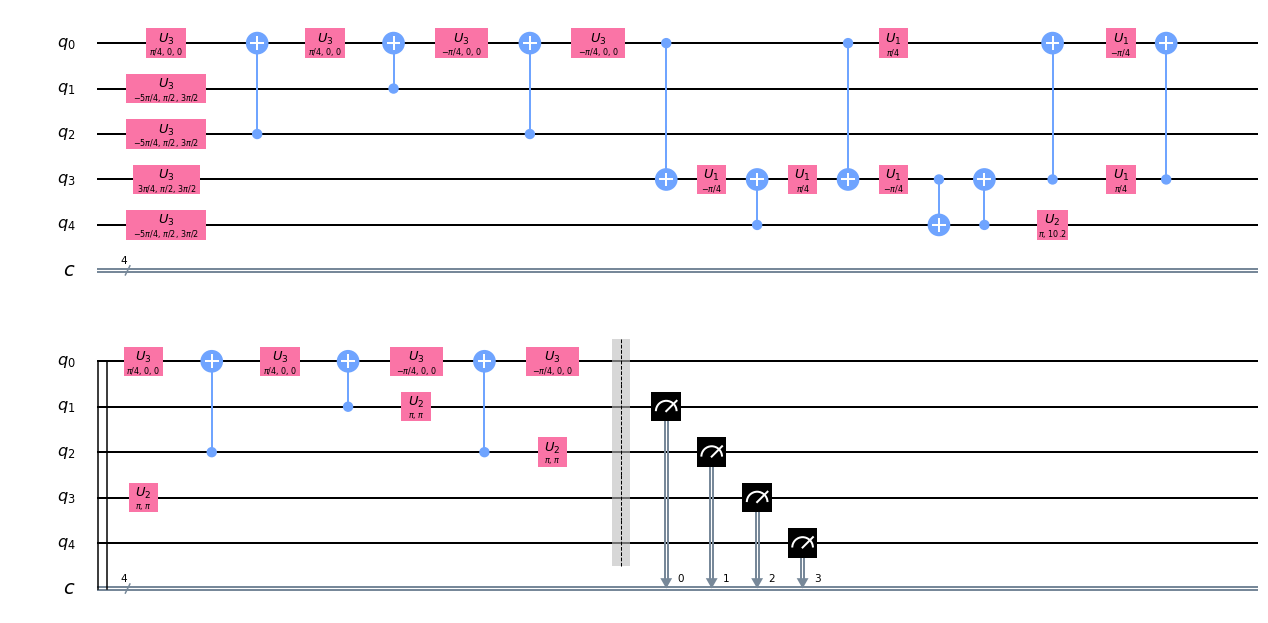

In [13]:
## Grover with RC3X_m(0.25pi)
circuit_list[0][0].draw(output="mpl")

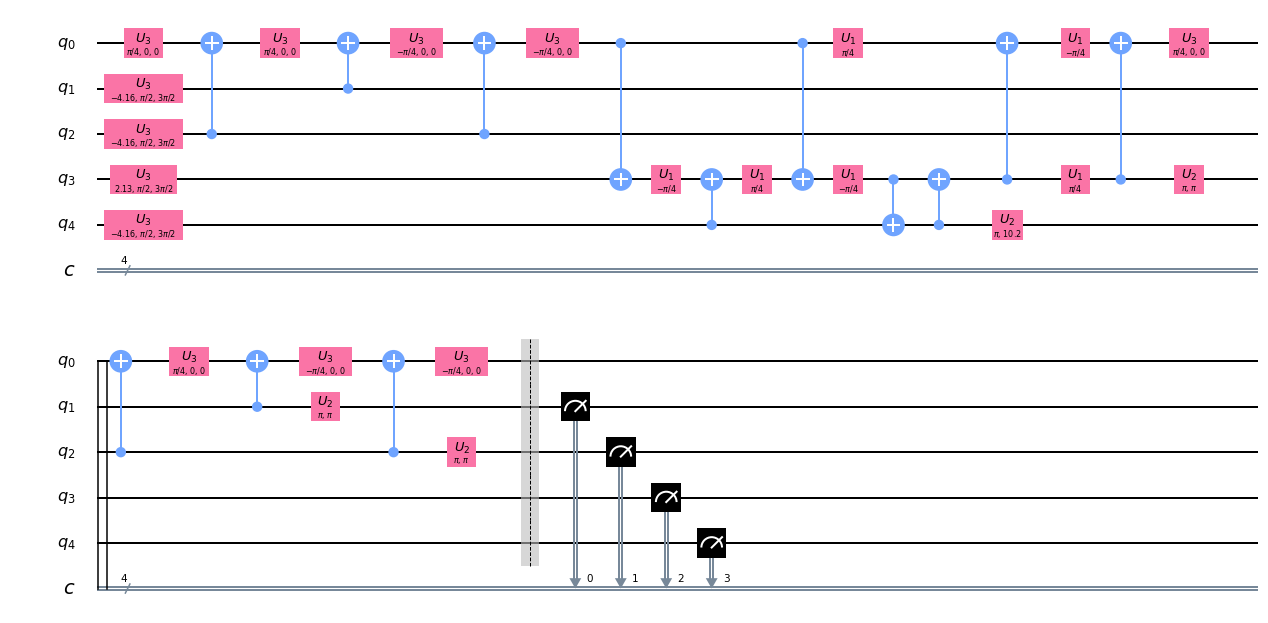

In [14]:
## Grover with RC3X_m(0.32pi)
circuit_list[1][0].draw(output="mpl")

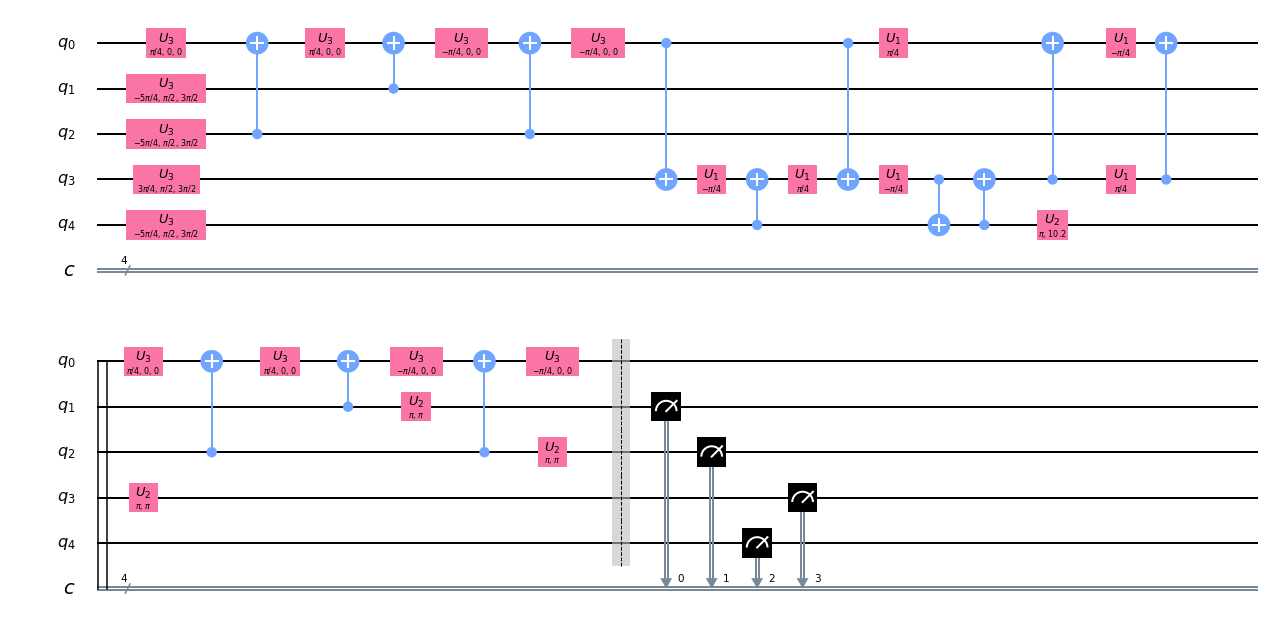

In [15]:
## Grover with RC3X_ix(0.25pi)
circuit_list[2][0].draw(output="mpl")

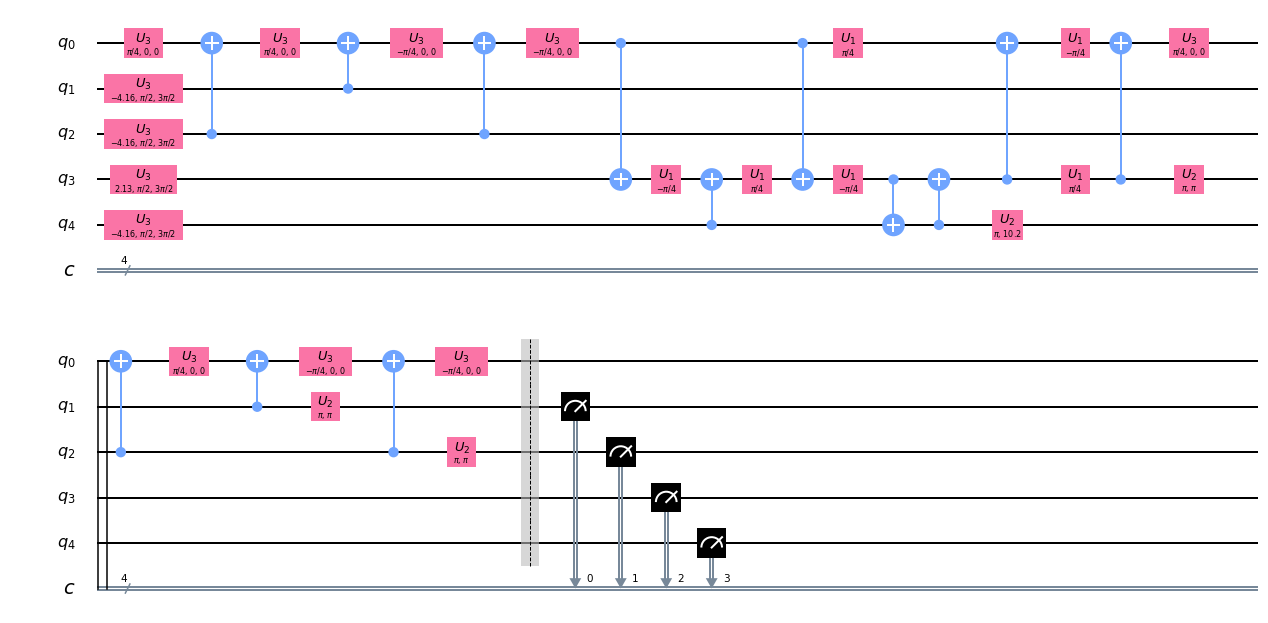

In [16]:
## Grover with RC3X_ix(0.32pi)
circuit_list[3][0].draw(output="mpl")

---
# QASM simulator

In [17]:
print("############ running on simulator #############")

simulator = Aer.get_backend('qasm_simulator')
shots=8192


print("################# executed #################" )


## Sort results in binary order
"""
Now, we have two circuits pattern, (theta=0.25pi and theta = 0.33pi).
And each of circuit has several patterns of qubit_mapping 

So repeat this 2*len(qubit_list) times.
"""

#
## define counts_sim as a list
counts_sim = []

for _circuit_num_list in circuit_list:
    result_sim = execute(_circuit_num_list[0], backend=simulator, shots = shots).result()
    counts_sim.append(result_sim.get_counts(0))


print(counts_sim)

############ running on simulator #############
################# executed #################
[{'1110': 556, '0010': 545, '1011': 521, '1010': 119, '0110': 107, '1111': 1647, '0000': 1618, '0011': 99, '0001': 525, '0101': 112, '0100': 554, '1000': 512, '0111': 506, '1001': 116, '1100': 100, '1101': 555}, {'1110': 624, '0010': 602, '1011': 624, '1010': 14, '0110': 18, '1111': 1739, '0000': 1732, '0011': 19, '0001': 564, '0101': 19, '0100': 558, '1000': 559, '0111': 550, '1001': 13, '1100': 12, '1101': 545}, {'1110': 534, '0010': 555, '1011': 548, '1010': 107, '0110': 113, '1111': 1572, '0000': 1622, '0011': 112, '0001': 587, '0101': 106, '0100': 511, '1000': 539, '0111': 531, '1001': 117, '1100': 94, '1101': 544}, {'1110': 582, '0010': 586, '1011': 556, '1010': 20, '0110': 13, '1111': 1725, '0000': 1796, '0011': 9, '0001': 569, '0101': 12, '0100': 589, '1000': 556, '0111': 566, '1001': 12, '1100': 7, '1101': 594}]


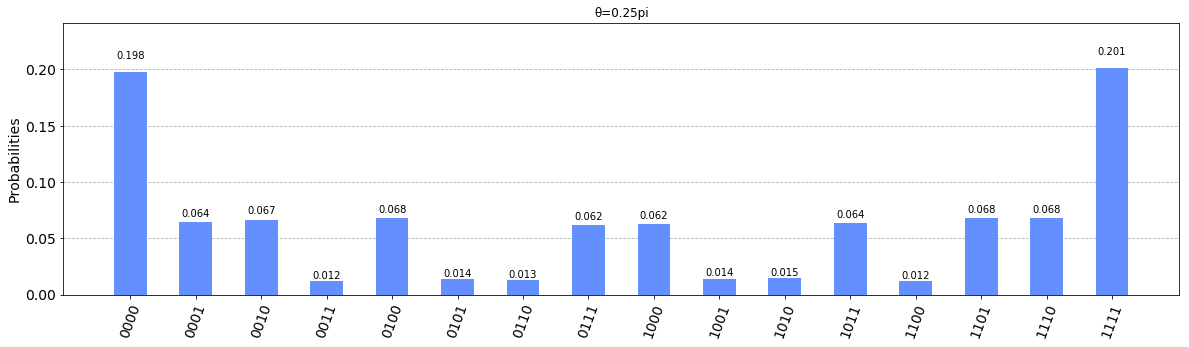

In [18]:
plot_histogram(counts_sim[0], figsize=(20, 5), title="θ=0.25pi")

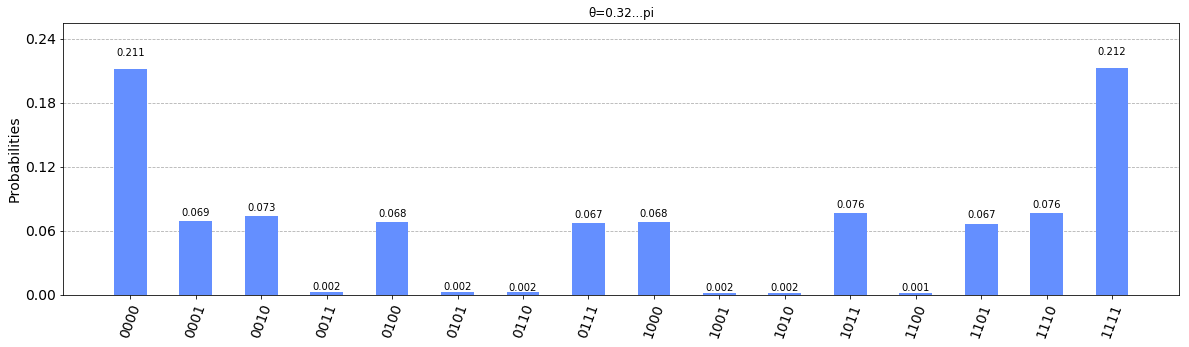

In [19]:
plot_histogram(counts_sim[1], figsize=(20, 5), title="θ=0.32...pi")

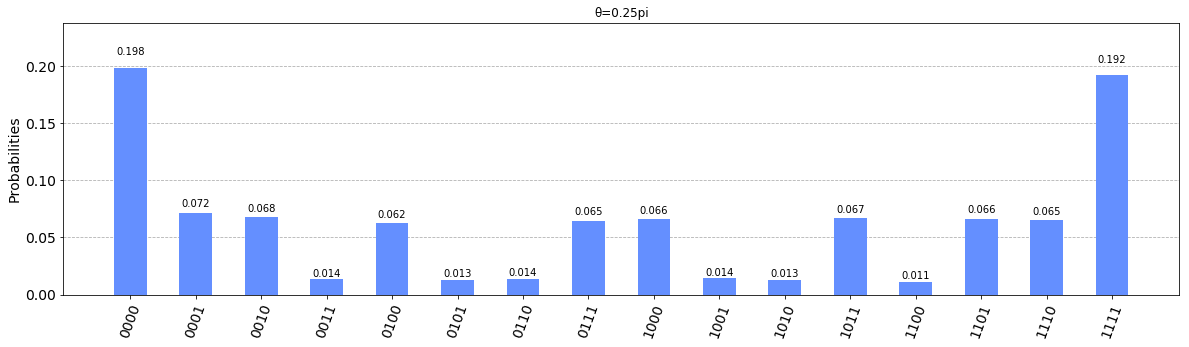

In [20]:
plot_histogram(counts_sim[2], figsize=(20, 5), title="θ=0.25pi")

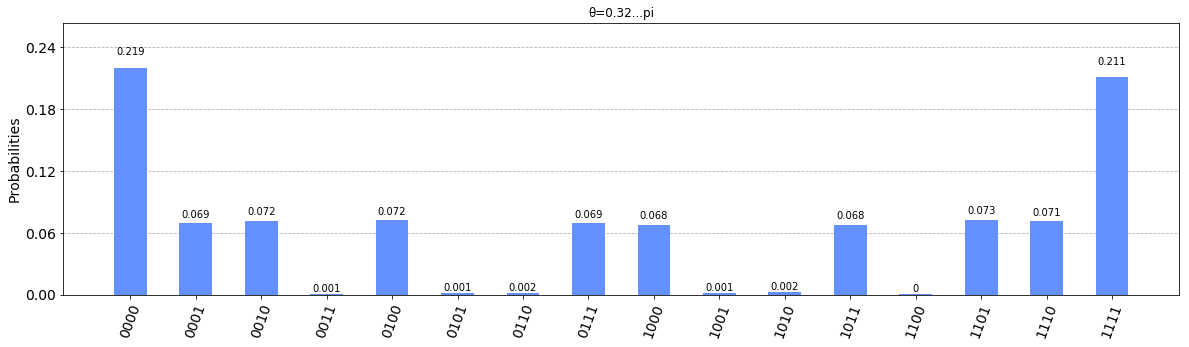

In [21]:
plot_histogram(counts_sim[3], figsize=(20, 5), title="θ=0.32...pi")

---
# Real device

In [22]:
a_day = datetime(2020, 1, 1)
backend = provider.backends.ibmq_ourense
prop = backend.properties(datetime=a_day)

_qubit_key_list = list(prop._gates.get('u1').keys())

u2_error_20200101_list = [prop._gates.get('u2').get((0, )).get('gate_error')[0] for qubit in _qubit_key_list]
print('u2_error_20200101_list = ', u2_error_20200101_list)

u3_error_20200101_list = [prop._gates.get('u3').get((0, )).get('gate_error')[0] for qubit in _qubit_key_list]
print('u3_error_20200101_list = ', u3_error_20200101_list)

_cx_key_list = list(prop._gates.get('cx').keys())
cx_error_20200101_list = [prop._gates.get('cx').get(cx_connection).get('gate_error')[0] for cx_connection in _cx_key_list]
print('cx_error_20200101_list = ', cx_error_20200101_list)

u2_error_20200101_list =  [0.0003042990376713585, 0.0003042990376713585, 0.0003042990376713585, 0.0003042990376713585, 0.0003042990376713585]
u3_error_20200101_list =  [0.000608598075342717, 0.000608598075342717, 0.000608598075342717, 0.000608598075342717, 0.000608598075342717]
cx_error_20200101_list =  [0.007224412408083414, 0.007224412408083414, 0.009546878329904501, 0.013416648333958975, 0.009546878329904501, 0.013416648333958975, 0.0073463600989708, 0.0073463600989708]


### Finding the qubit mapping

In [23]:
## Get qubit coupling map
conf = device.configuration()
coupling_map = conf.coupling_map
print(coupling_map)

[[0, 1], [1, 0], [1, 2], [1, 3], [2, 1], [3, 1], [3, 4], [4, 3]]


In [24]:
## searching the qubit mapping list from coupling_map
from collections import Counter
import copy
    
hub_list = [qubit for qubit, cnt in Counter(np.ravel(coupling_map)).most_common() if cnt>=6]

t_qubit_list = []
for hub in hub_list:
    branch = [con[1] for con in coupling_map if con[0]==hub]
    tale_list = [tale for tale in coupling_map if(tale[1]!=hub and tale[1] not in branch) for bra in branch if(tale[0]==bra)]
    
    tale_mapping_list = []
    for tale in tale_list:
        
        t_list = []
        t_list.append(hub)
        for bra in branch:
            if bra != tale[0]:
                t_list.append(bra)
        t_list.extend(tale)
        tale_mapping_list.append(t_list)
    
    t_qubit_list.append(tale_mapping_list)


qubit_mapping = []
for hub_map in t_qubit_list:
    tale_mapping = []
    for tale_map in hub_map:
        mapping1 = copy.copy(tale_map)
        tale_mapping.append(mapping1)
        
        tale_map[1], tale_map[2] = tale_map[2], tale_map[1]

        mapping2 = copy.copy(tale_map)
        tale_mapping.append(mapping2)
    qubit_mapping.append(tale_mapping)
    
## mitigation mapping


print("qubit_mapping = ", qubit_mapping)

qubit_mapping =  [[[1, 0, 2, 3, 4], [1, 2, 0, 3, 4]]]


In [25]:
qubit_mapping = [[[1, 0, 2, 3, 4], [1, 2, 0, 3, 4]]]
cal_mapping = [[[0, 2, 4, 3], [2, 0, 4, 3]]]

### 4-2. Define mitigation circuit

In [26]:
qr = QuantumRegister(4)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')

In [27]:
print(meas_calibs)
print(state_labels)

[<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a2b47d6d8>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a2b47d128>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a2b47d908>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a2b47d2b0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a2b0acc18>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a2b0ac898>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a2ab22160>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a2a9c2fd0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a2b0d56a0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a2b0d52b0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a2b0d50f0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a2b72fe10>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a2ab36ba8>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1a2b067c18>, <qisk

### Execution

In [28]:
# ## define shots
# shots = 8192

# ## define the lists to store job_id
# job_id_list = []
# cal_job_id_list = []

# # result_exp_list = []
# # result_cal_exp_list = []

# ## repeat # of hub_qubits times
# for hub, cal_hub in zip(qubit_mapping, cal_mapping):
    
#     ## repeat # of qubit_mapping per each hub_qubit times
#     for mapping, cal_map in zip(hub, cal_hub):
#         _mapping_job_id_list = []
#         _mapping_cal_job_id_list = []
        
#         ## repeat # of circuit_num times
#         for circuit_num_list in circuit_list:
#             if num_run < 100:  
#                 num_job = int(100/num_run)
#                 _exec_100_list = []
#                 for i in range(num_job):
#           
#                     ## job for circuit execution
#                     job_exp = execute(circuit_num_list,
#                                       backend = device,
# #                                       backend = simulator,
#                                       shots = shots,
#                                       initial_layout=mapping,
#                                       optimization_level = 0
#                                      )
#                     _exec_100_list.append(job_exp.job_id())
#                     print('sent the job', mapping)
#                 _mapping_job_id_list.append(_exec_100_list)
            
#             else: 
#                 ## job for circuit execution
#                 job_exp = execute(circuit_num_list,
#                                   backend = device,
# #                                       backend = simulator,
#                                   shots = shots,
#                                   initial_layout=mapping,
#                                   optimization_level = 0
#                                  )
#                 print('sent the job', mapping)
#                 _mapping_job_id_list.append(job_exp.job_id())


#         ## job for meas_cal
#         cal_job = execute(meas_calibs, 
#                         backend = device,
# #                         backend = simulator,
#                         shots=shots,
#                         initial_layout=cal_map,
#                         optimization_level=0
#                         )
#         _mapping_cal_job_id_list.append(cal_job.job_id())
#         print('sent the cal_job', mapping)

#         job_id_list.append(_mapping_job_id_list)
#         cal_job_id_list.append(_mapping_cal_job_id_list)


# print('job_id_list = ', job_id_list)
# print('cal_job_id_list = ', cal_job_id_list)

In [29]:
job_id_list =  [[
    ['5e0c0eea06766d001137b932'], ['5e0c0ef439e9810012554d6b'], ['5e0c0efdefb76e0011437e98'], ['5e0c0f067272e100112dd4e9']], 
    [['5e0c0f12ee2824001150c899'], ['5e0c0f1a7272e100112dd4ec'], ['5e0c0f22efb76e0011437e9d'], ['5e0c0f2fe7977f001127cb71']]]
cal_job_id_list =  [['5e0c0f09efb76e0011437e9a'], ['5e0c0f3206766d001137b937']]

### 4-4. retrieve the job and get the result

In [30]:
# Define the list to store the result_exp for error mitigation
result_exp_list = []
result_cal_exp_list = []

for job_id_mapping, cal_job_id_mapping in zip(job_id_list, cal_job_id_list):
    
    result_exp_mapping_list = []
    result_cal_exp_mapping_list = []
    
    for job_id_run in job_id_mapping:
        _job_id_run_list=[]
        for job_id in job_id_run:
            ## retrieve jobs
            retrieved_job = device.retrieve_job(job_id)
            print("jobs were retrieved")
            result_exp = retrieved_job.result()
            print("got exp result")
            _job_id_run_list.append(result_exp)
        
        ## Append results_exp to the result_exp_list for error mitigation operation
        result_exp_mapping_list.append(_job_id_run_list)
        
    for cal_job_id in cal_job_id_mapping:
        ## retrieve jobs
        retrieved_cal_job = device.retrieve_job(cal_job_id)
        print("jobs were retrieved")
        
        result_cal_exp = retrieved_cal_job.result()
        print("got cal_exp result")
        result_cal_exp_mapping_list.append(result_cal_exp)
        
    ## Append results_exp to the result_exp_list for error mitigation operation
    result_exp_list.append(result_exp_mapping_list)
    result_cal_exp_list.append(result_cal_exp_mapping_list)

print(result_exp_list)
print(result_cal_exp_list)

jobs were retrieved
got exp result
jobs were retrieved
got exp result
jobs were retrieved
got exp result
jobs were retrieved
got exp result
jobs were retrieved
got cal_exp result
jobs were retrieved
got exp result
jobs were retrieved
got exp result
jobs were retrieved
got exp result
jobs were retrieved
got exp result
jobs were retrieved
got cal_exp result
[[[Result(backend_name='ibmq_ourense', backend_version='1.0.1', date=datetime.datetime(2020, 1, 1, 3, 33, 30, tzinfo=datetime.timezone.utc), execution_id='6dd1cbb4-2c46-11ea-86ac-ac1f6b47c318', header=Obj(backend_name='ibmq_ourense', backend_version='1.0.1'), job_id='5e0c0eea06766d001137b932', qobj_id='f3f999b5-f902-406a-9f9c-2295a43cdb57', results=[ExperimentResult(data=ExperimentResultData(counts=Obj(0x0=1089, 0x1=995, 0x2=837, 0x3=677, 0x4=551, 0x5=419, 0x6=297, 0x7=325, 0x8=498, 0x9=400, 0xa=243, 0xb=290, 0xc=382, 0xd=415, 0xe=334, 0xf=440)), header=Obj(clbit_labels=[['c', 0], ['c', 1], ['c', 2], ['c', 3]], creg_sizes=[['c', 4]], 

In [31]:
counts_exp_list = [[[
                [result_exp_num_run.get_counts(circ) for circ in range(num_run)]
            for result_exp_num_run in result_exp] 
        for result_exp in mapping_list] 
    for mapping_list in result_exp_list]

print("counts_exp_list = ", counts_exp_list, "\n")

counts_exp_list =  [[[[{'1110': 334, '0010': 837, '1011': 290, '1010': 243, '0110': 297, '1111': 440, '0000': 1089, '0011': 677, '0001': 995, '0101': 419, '0100': 551, '1000': 498, '0111': 325, '1001': 400, '1100': 382, '1101': 415}, {'1110': 347, '0010': 784, '1011': 300, '1010': 240, '0110': 293, '1111': 438, '0000': 1077, '0011': 690, '0001': 973, '0101': 418, '0100': 578, '1000': 524, '0111': 341, '1001': 422, '1100': 349, '1101': 418}, {'1110': 310, '0010': 750, '1011': 281, '1010': 236, '0110': 298, '1111': 477, '0000': 1067, '0011': 679, '0001': 1012, '0101': 458, '0100': 591, '1000': 519, '0111': 305, '1001': 422, '1100': 388, '1101': 399}, {'1110': 305, '0010': 726, '1011': 328, '1010': 222, '0110': 306, '1111': 453, '0000': 1068, '0011': 653, '0001': 955, '0101': 439, '0100': 586, '1000': 572, '0111': 327, '1001': 413, '1100': 411, '1101': 428}, {'1110': 343, '0010': 720, '1011': 323, '1010': 246, '0110': 298, '1111': 440, '0000': 1097, '0011': 697, '0001': 1025, '0101': 420,

# Plot data

### post data processing

In [32]:
binlist = [format(i, '04b') for i in range(16)]
values_exp_list = [[[[[100*counts[i]/shots for i in binlist] for counts in counts_num_run] for counts_num_run in num_circ] for num_circ in mapping_list ] for mapping_list in counts_exp_list]

In [34]:
def list_mean(arr):
    _mapping_mean_num_circ_list = []
    for mapping in arr:
        _mean_num_circ_list = []
        
        for num_circ in mapping:
            _num_circ_list = []
            
            for num_run in num_circ:
                _mean_num_run=np.mean(num_run, axis=0)
                _num_circ_list.append(_mean_num_run)
            
            mean_num_circ = np.mean(_num_circ_list, axis=0)
            _mean_num_circ_list.append(mean_num_circ)
            
        _mapping_mean_num_circ_list.append(_mean_num_circ_list)

    _mean=np.mean(_mapping_mean_num_circ_list, axis=0)
    return _mean


def list_min(arr):
    _mapping_min_num_circ_list = []
    for mapping in arr:
        _min_num_circ_list = []
        
        for num_circ in mapping:
            _num_circ_list = []
            
            for num_run in num_circ:
                _min_num_run=np.min(num_run, axis=0)
                _num_circ_list.append(_min_num_run)
            
            min_num_circ = np.min(_num_circ_list, axis=0)
            _min_num_circ_list.append(min_num_circ)
            
        _mapping_min_num_circ_list.append(_min_num_circ_list)

    _min=np.min(_mapping_min_num_circ_list, axis=0)
    return _min

def list_max(arr):
    _mapping_max_num_circ_list = []
    for mapping in arr:
        _max_num_circ_list = []
        
        for num_circ in mapping:
            _num_circ_list = []
            
            for num_run in num_circ:
                _max_num_run=np.max(num_run, axis=0)
                _num_circ_list.append(_max_num_run)
            
            max_num_circ = np.max(_num_circ_list, axis=0)
            _max_num_circ_list.append(max_num_circ)
            
        _mapping_max_num_circ_list.append(_max_num_circ_list)

    _max=np.max(_mapping_max_num_circ_list, axis=0)
    return _max

In [35]:
values_sim = [[100*_counts_num_circ[i]/shots for i in binlist ] for _counts_num_circ in counts_sim ]
values_exp = list_mean(values_exp_list)
values_exp_max = list_max(values_exp_list)
values_exp_min = list_min(values_exp_list)

In [36]:
np.set_printoptions(threshold=np.inf)
print("values_sim = ", values_sim, "\n")
print("values_exp = ", values_exp, "\n")
print("values_exp_max = ", values_exp_max, "\n")
print("values_exp_min = ", values_exp_min, "\n")

values_sim =  [[19.7509765625, 6.40869140625, 6.65283203125, 1.20849609375, 6.7626953125, 1.3671875, 1.30615234375, 6.1767578125, 6.25, 1.416015625, 1.45263671875, 6.35986328125, 1.220703125, 6.77490234375, 6.787109375, 20.10498046875], [21.142578125, 6.884765625, 7.3486328125, 0.23193359375, 6.8115234375, 0.23193359375, 0.2197265625, 6.7138671875, 6.82373046875, 0.15869140625, 0.1708984375, 7.6171875, 0.146484375, 6.65283203125, 7.6171875, 21.22802734375], [19.7998046875, 7.16552734375, 6.77490234375, 1.3671875, 6.23779296875, 1.2939453125, 1.37939453125, 6.48193359375, 6.57958984375, 1.42822265625, 1.30615234375, 6.689453125, 1.1474609375, 6.640625, 6.5185546875, 19.189453125], [21.923828125, 6.94580078125, 7.1533203125, 0.10986328125, 7.18994140625, 0.146484375, 0.15869140625, 6.9091796875, 6.787109375, 0.146484375, 0.244140625, 6.787109375, 0.08544921875, 7.2509765625, 7.1044921875, 21.05712890625]] 

values_exp =  [[12.94934082 10.77307129 10.17224121  8.54675293  6.55554199  4.28

### Plot

In [37]:
color = ['#648fff', '#dc267f', '#785ef0', '#ffb000', '#fe6100']

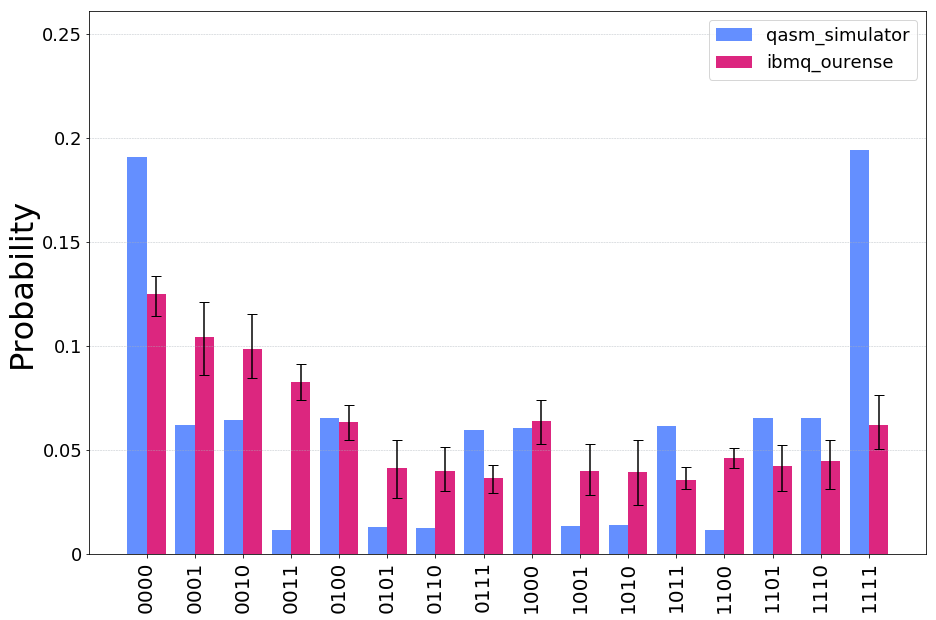

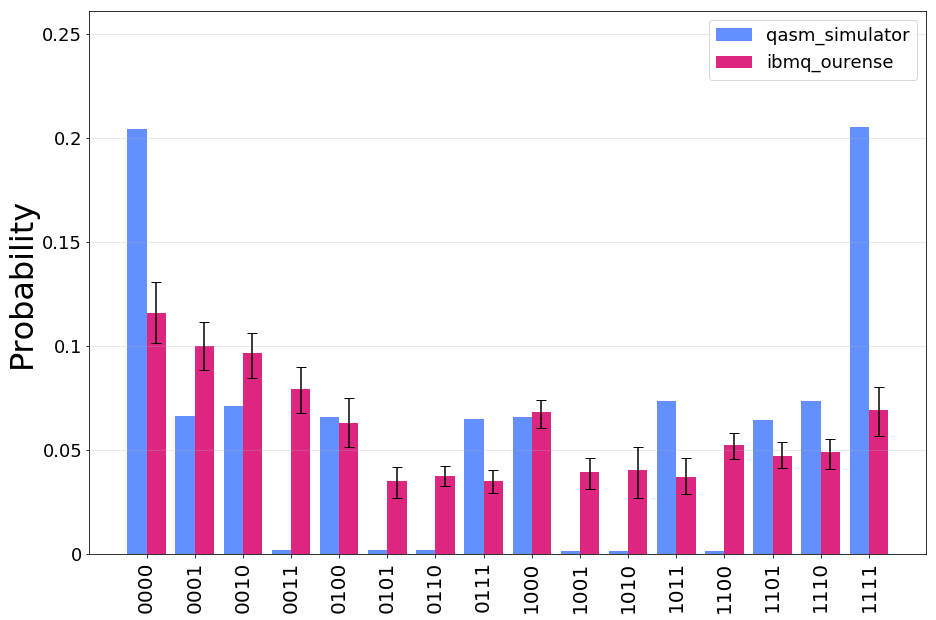

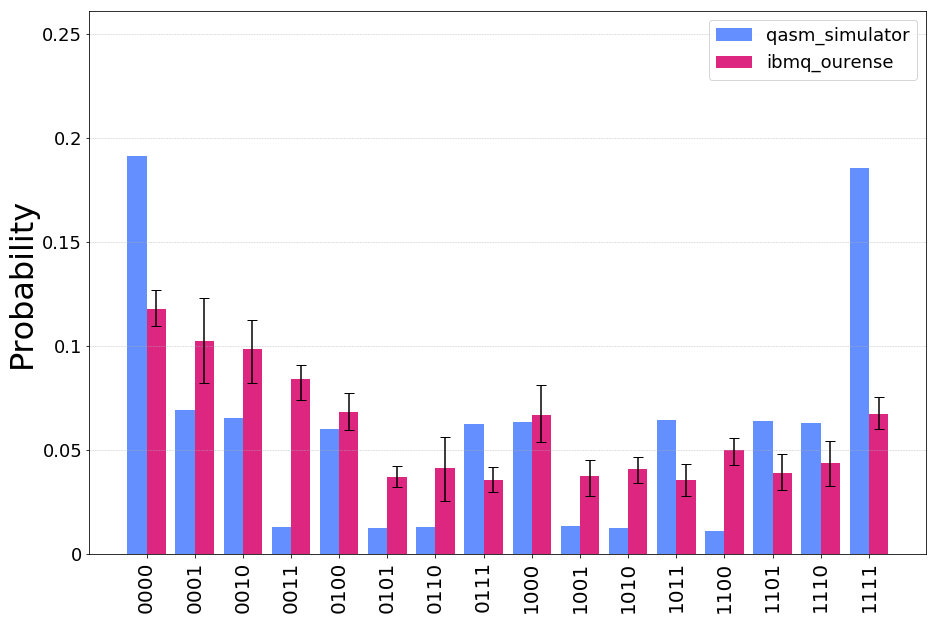

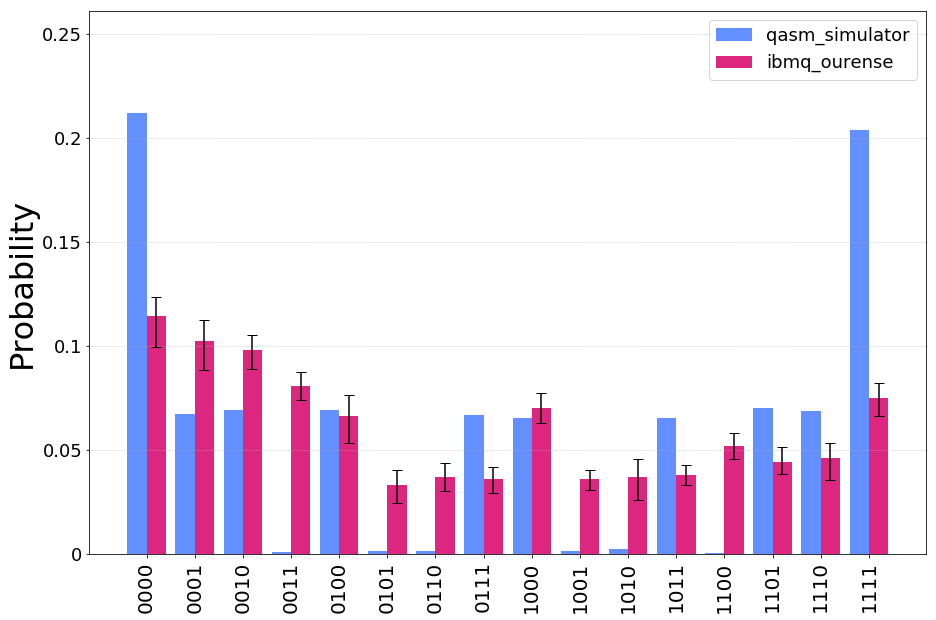

In [38]:
## define figure size
w = 0.4


for sim, exp, exp_max, exp_min in zip(values_sim, values_exp, values_exp_max, values_exp_min):
    fig,ax = plt.subplots(figsize=(15, 10))

    ## set title
    # plt.title('MAX-CUT approx-grover(θ='+str(theta)+')\n qubit_map='+str(qubit_list)+' '+str(date), fontsize=20)
    # plt.title(str(backend), fontsize=32)

    ## define bar propaty
    plt.bar(np.arange(len(sim)), sim, color=color[0], width=w, label="qasm_simulator", align='center') ## simulator
    plt.bar(np.arange(len(exp))+w, exp, color=color[1], width=w, label=device, align='center') ## real device
    plt.errorbar(np.arange(len(exp))+w, exp, [exp_max-exp, exp-exp_min], ecolor='black', fmt='none', capsize=5)


    ## set y-axis
    ax.grid(which = "major", axis = "y", color = '#ABB2B9', alpha = 0.8, linestyle = "--", linewidth = 0.5)
    ax.set_yticks(np.linspace(0, 31, 7))
    plt.ylabel("Probability", fontsize= 32)
    ax.set_yticklabels(["0", "0.05", "0.1", "0.15", "0.2", "0.25", "0.3"])
    plt.ylim(0, 27)
    plt.yticks(fontsize=18)

    ## set x-axis
    plt.xticks(np.arange(len(binlist))+w/2, binlist, rotation=90, fontsize=20)

    ## set legend
    plt.legend(fontsize=18)

    plt.show()

---
# Readout Error mitigation

The calibration matrix 

[[9.24316406e-01 3.43017578e-02 1.63696289e-01 8.78906250e-03
  1.30126953e-01 5.00488281e-03 2.24609375e-02 1.58691406e-03
  5.59082031e-02 3.17382812e-03 1.42822266e-02 9.76562500e-04
  1.14746094e-02 1.22070312e-04 3.17382812e-03 1.22070312e-04]
 [1.35498047e-02 8.95874023e-01 2.44140625e-03 1.62475586e-01
  1.83105469e-03 1.21704102e-01 1.22070312e-04 2.38037109e-02
  1.09863281e-03 4.88281250e-02 1.22070312e-04 1.41601562e-02
  4.88281250e-04 1.24511719e-02 1.22070312e-04 1.95312500e-03]
 [1.02539062e-02 2.44140625e-04 7.74169922e-01 3.22265625e-02
  1.46484375e-03 1.22070312e-04 1.02539062e-01 3.90625000e-03
  9.76562500e-04 0.00000000e+00 4.67529297e-02 2.31933594e-03
  0.00000000e+00 0.00000000e+00 9.39941406e-03 3.66210938e-04]
 [1.22070312e-04 1.04980469e-02 9.88769531e-03 7.40478516e-01
  0.00000000e+00 1.58691406e-03 9.76562500e-04 9.66796875e-02
  0.00000000e+00 7.32421875e-04 1.83105469e-03 4.83398438e-02
  0.00000000e+00 0.00000000e+00 3.66210938

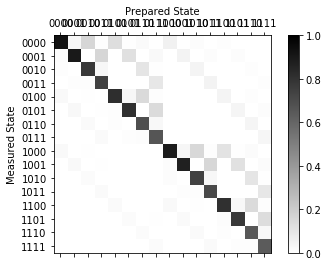

Average Measurement Fidelity: 0.775734 

The calibration matrix 

[[9.19555664e-01 1.51000977e-01 3.68652344e-02 8.91113281e-03
  9.70458984e-02 1.62353516e-02 4.02832031e-03 1.22070312e-03
  5.88378906e-02 1.44042969e-02 2.80761719e-03 9.76562500e-04
  1.01318359e-02 3.17382812e-03 7.32421875e-04 1.22070312e-04]
 [1.92871094e-02 7.83935547e-01 1.22070312e-03 2.89306641e-02
  2.44140625e-03 8.61816406e-02 0.00000000e+00 5.00488281e-03
  9.76562500e-04 4.52880859e-02 0.00000000e+00 1.70898438e-03
  1.22070312e-04 8.91113281e-03 0.00000000e+00 1.22070312e-04]
 [1.18408203e-02 1.58691406e-03 8.88793945e-01 1.46728516e-01
  1.22070312e-03 0.00000000e+00 1.04370117e-01 1.73339844e-02
  1.83105469e-03 3.66210938e-04 5.00488281e-02 1.42822266e-02
  0.00000000e+00 3.66210938e-04 1.12304688e-02 2.31933594e-03]
 [0.00000000e+00 8.78906250e-03 1.87988281e-02 7.61108398e-01
  0.00000000e+00 8.54492188e-04 2.19726562e-03 8.17871094e-02
  0.00000000e+00 7.32421875e-04 1.09863281e-03 4.41894531e-02
 

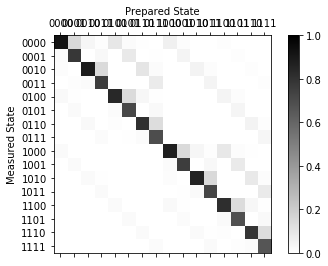

Average Measurement Fidelity: 0.787727 



In [39]:
meas_fitter_list = []

for result_cal_exp in result_cal_exp_list:
    
    ## define measurement fitter
    meas_fitter = CompleteMeasFitter(result_cal_exp[0], state_labels)
    meas_fitter_list.append(meas_fitter)
    
    print("The calibration matrix \n")
    print(meas_fitter.cal_matrix)

    ## Plot the calibration matrix
    print("Plot the calibration matrix (2D color grid plot)\n")
    meas_fitter.plot_calibration()

    ## The measurement fidelity
    print("Average Measurement Fidelity: %f" % meas_fitter.readout_fidelity(), "\n")

### Apply device calibration parameter to mitigate the result_exp

In [55]:
print(len(result_exp_list[0][0]))

1


In [56]:
## define the list to store 
counts_mit_list = []

## repeat # of qubit_mapping times
for mapping_list, meas_fitter in zip(result_exp_list, meas_fitter_list):
    
    _mit_mapping_list = []
    meas_filter = meas_fitter.filter
    
    for result_num_run in mapping_list:
        _mit_counts_num_run_list = []
        
        for results_exp in result_num_run:
            ## get measurement error mitigated result
            mitigated_results = meas_filter.apply(results_exp)
            mitigated_counts = [mitigated_results.get_counts(circ) for circ in range(num_run)]        
            _mit_counts_num_run_list.append(mitigated_counts)
            
        _mit_mapping_list.append(_mit_counts_num_run_list)
            
        
    ## Append mitigated_counts to mitigated_list
    counts_mit_list.append(_mit_mapping_list)

### Show the mitigated counts

In [57]:
print("counts_mit_list = ", counts_mit_list, "\n")

counts_mit_list =  [[[[{'1011': 287.09227204804574, '0111': 409.77606022383185, '1001': 300.6643314556845, '1000': 420.4846741625198, '1101': 391.0074384276182, '1110': 455.04188275298634, '0101': 372.5650589128127, '1010': 214.60834055792577, '0011': 807.3541076564709, '0010': 966.8905392407858, '1100': 338.6043854921123, '1111': 648.0973792404363, '0000': 845.6634669796214, '0001': 857.6049571749319, '0100': 530.1777963060508, '0110': 346.3673093681653}, {'1011': 301.0602246657029, '0111': 433.6900062348336, '1001': 323.2199585692571, '1000': 455.51055462899086, '1101': 395.5077362482679, '1110': 476.28099942627006, '0101': 367.38176416341764, '1010': 208.1010514358733, '0011': 822.2464918746675, '0010': 898.6126238569263, '1100': 291.6594568373609, '1111': 643.5061354806318, '0000': 839.0339406587585, '0001': 829.1058573997794, '0100': 567.0882512292786, '0110': 339.9949472899835}, {'1011': 265.95604182339827, '0111': 375.5032912832585, '1001': 331.87254590561156, '1000': 443.345859

In [58]:
for i in range(4):
    print(counts_mit_list[0][i][0][0].get('0000'))

845.6634669796214
809.3637899686803
716.1665706803634
650.807904716192


---
# Plot results

### post data processing

In [59]:
binlist = [format(i, '04b') for i in range(16)]
values_exp_list = [[[[[100*counts[i]/shots for i in binlist] for counts in counts_num_run] for counts_num_run in num_circ] for num_circ in mapping_list ] for mapping_list in counts_exp_list]
values_mit_list = [[[[[100*counts[i]/shots for i in binlist] for counts in counts_num_run] for counts_num_run in num_circ] for num_circ in mapping_list ] for mapping_list in counts_mit_list]

print(values_mit_list[0][3][0][0][0])

7.944432430617578


In [60]:
values_mit = list_mean(values_mit_list)
values_mit_max = list_max(values_mit_list)
values_mit_min = list_min(values_mit_list)

In [61]:
np.set_printoptions(threshold=np.inf)
print("values_sim = ", values_sim, "\n")
print("values_exp = ", values_exp, "\n")
print("values_exp_max = ", values_exp_max, "\n")
print("values_exp_min = ", values_exp_min, "\n")
print("values_mit = ", values_mit, "\n")
print("values_mit_max = ", values_mit_max, "\n")
print("values_mit_min = ", values_mit_min, "\n")

values_sim =  [[19.7509765625, 6.40869140625, 6.65283203125, 1.20849609375, 6.7626953125, 1.3671875, 1.30615234375, 6.1767578125, 6.25, 1.416015625, 1.45263671875, 6.35986328125, 1.220703125, 6.77490234375, 6.787109375, 20.10498046875], [21.142578125, 6.884765625, 7.3486328125, 0.23193359375, 6.8115234375, 0.23193359375, 0.2197265625, 6.7138671875, 6.82373046875, 0.15869140625, 0.1708984375, 7.6171875, 0.146484375, 6.65283203125, 7.6171875, 21.22802734375], [19.7998046875, 7.16552734375, 6.77490234375, 1.3671875, 6.23779296875, 1.2939453125, 1.37939453125, 6.48193359375, 6.57958984375, 1.42822265625, 1.30615234375, 6.689453125, 1.1474609375, 6.640625, 6.5185546875, 19.189453125], [21.923828125, 6.94580078125, 7.1533203125, 0.10986328125, 7.18994140625, 0.146484375, 0.15869140625, 6.9091796875, 6.787109375, 0.146484375, 0.244140625, 6.787109375, 0.08544921875, 7.2509765625, 7.1044921875, 21.05712890625]] 

values_exp =  [[12.94934082 10.77307129 10.17224121  8.54675293  6.55554199  4.28

### Plot

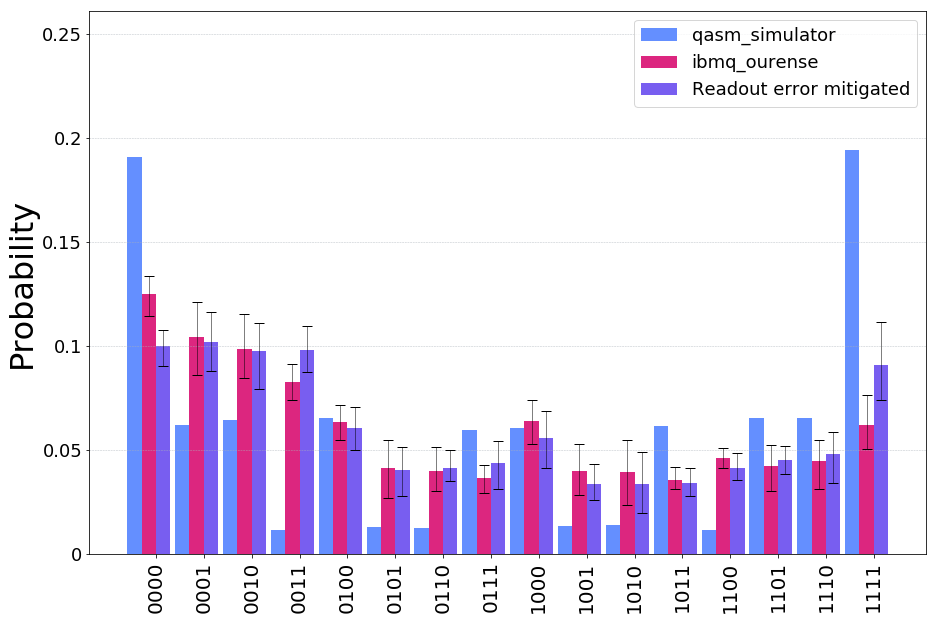

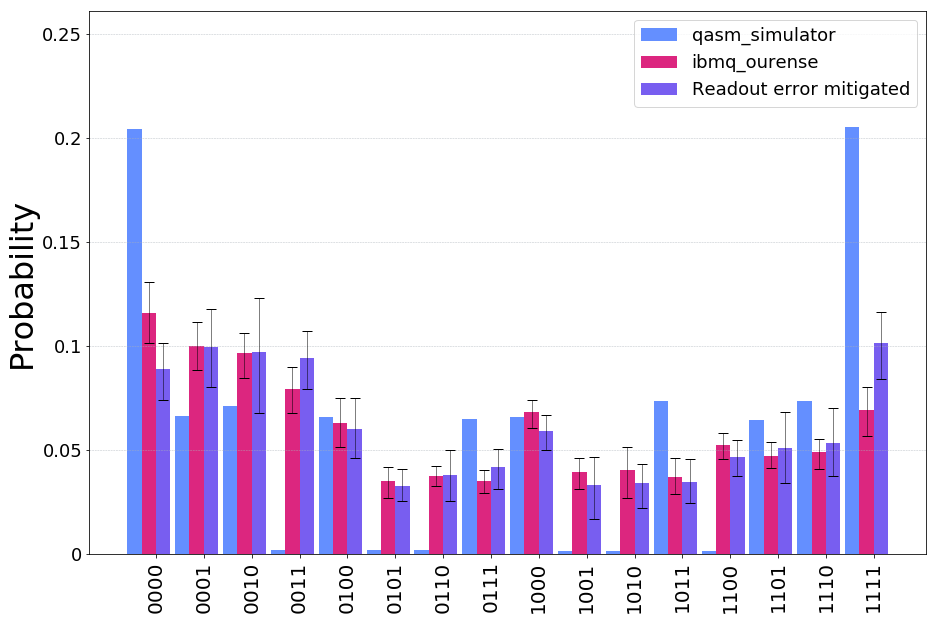

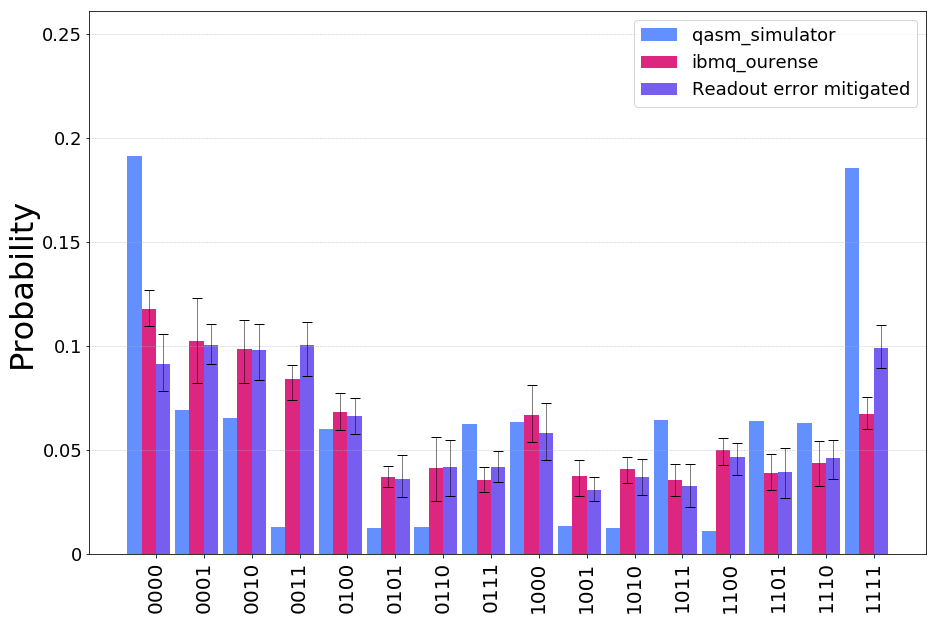

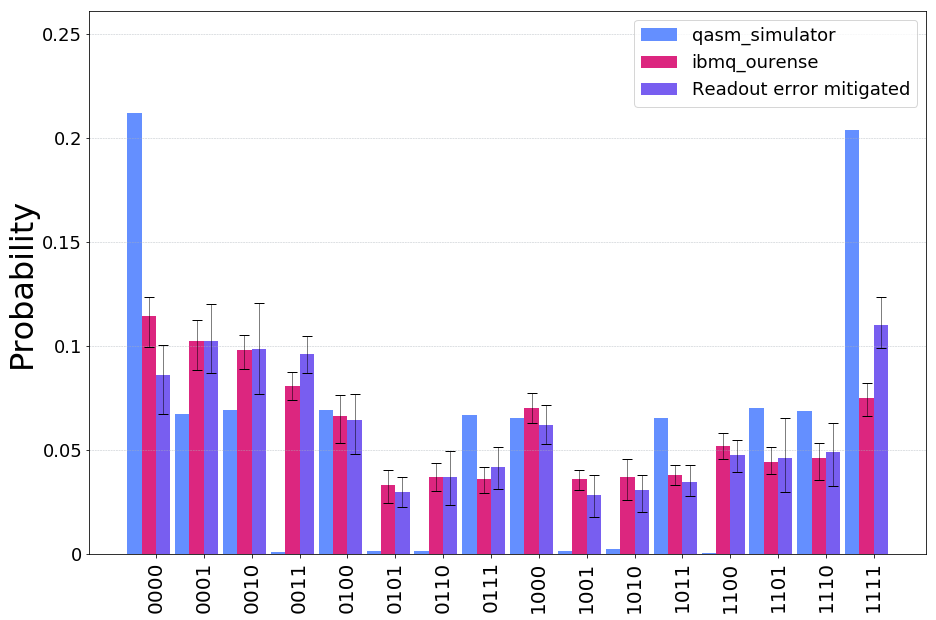

In [62]:
## define figure size
w = 0.3

for sim, exp, mit, max_exp, min_exp, max_mit, min_mit in zip(values_sim, values_exp, values_mit, values_exp_max, values_exp_min, values_mit_max, values_mit_min):
    fig,ax = plt.subplots(figsize=(15, 10))

    ## set title
    # plt.title('MAX-CUT approx-grover(θ='+str(theta)+')\n qubit_map='+str(qubit_list)+' '+str(date), fontsize=20)
    # plt.title(str(backend), fontsize=32)

    ## define bar propaty
    plt.bar(np.arange(len(sim))-w, sim, color=color[0], width=w, label="qasm_simulator", align='center') ## simulator
    plt.bar(np.arange(len(exp)), exp, color=color[1], width=w, label=device, align='center') ## real device
    plt.bar(np.arange(len(mit))+w, mit, color=color[2], width=w, label="Readout error mitigated", align='center') ## real device

    plt.errorbar(np.arange(len(exp)), exp, [max_exp-exp, exp-min_exp], fmt='none', ecolor="#000000", capsize=5, linewidth = 0.5)
    plt.errorbar(np.arange(len(mit))+w, mit, [max_mit-mit, mit-min_mit], fmt='none', ecolor="#000000",capsize=5, linewidth = 0.5)
    

    ## set y-axis
    ax.grid(which = "major", axis = "y", color = '#ABB2B9', alpha = 0.8, linestyle = "--", linewidth = 0.5)
    ax.set_yticks(np.linspace(0, 31, 7))
    plt.ylabel("Probability", fontsize= 32)
    ax.set_yticklabels(["0", "0.05", "0.1", "0.15", "0.2", "0.25", "0.3"])
    plt.ylim(0, 27)
    plt.yticks(fontsize=18)

    ## set x-axis
    plt.xticks(np.arange(len(binlist))+w/2, binlist, rotation=90, fontsize=20)

    ## set legend
    plt.legend(fontsize=18)

    plt.show()

# KL Divergance

### get arranged result

### define KL divergence

In [63]:
def klDivergence(P, Q, shots):
    kl = 0
    for i in range(len(P)):
        pp = P[i]/shots ## P[i] %
        qp = Q[i]/shots ## Q[i] %
        if(pp, qp!=0):
            kl_i = pp*np.log(pp/qp)
        kl += kl_i
    return kl

In [64]:
print(values_exp)
print(values_sim)

[[12.94934082 10.77307129 10.17224121  8.54675293  6.55554199  4.28955078
   4.15466309  3.76831055  6.60913086  4.15344238  4.08190918  3.71130371
   4.76379395  4.38891602  4.63696289  6.44506836]
 [12.00549316 10.34875488  9.9987793   8.2097168   6.51672363  3.6427002
   3.8972168   3.65539551  7.0604248   4.10253906  4.17675781  3.84509277
   5.41247559  4.88476562  5.07775879  7.16540527]
 [12.17895508 10.60498047 10.21264648  8.68518066  7.06384277  3.83630371
   4.27612305  3.6763916   6.9362793   3.87109375  4.24682617  3.69189453
   5.17431641  4.06005859  4.51965332  6.9654541 ]
 [11.81567383 10.58959961 10.13146973  8.37866211  6.85998535  3.42675781
   3.83349609  3.72167969  7.24230957  3.72070312  3.83276367  3.9206543
   5.3951416   4.59533691  4.78295898  7.75280762]]
[[19.7509765625, 6.40869140625, 6.65283203125, 1.20849609375, 6.7626953125, 1.3671875, 1.30615234375, 6.1767578125, 6.25, 1.416015625, 1.45263671875, 6.35986328125, 1.220703125, 6.77490234375, 6.787109375,

In [65]:
kl = [klDivergence(exp_val, sim_val, shots) for exp_val, sim_val in zip(values_exp, values_sim)]
methods = ["0.25π, R-C3X_m", "0.32π, R-C3X_m", "0.25π, R-C3X_ix", "0.32π, R-C3X_ix"]

print('methods =', methods,'\n' )
# print('sim_val=\n', sim_val)
# print('exp_val=\n', exp_val)
print('kl = \n', kl)

methods = ['0.25π, R-C3X_m', '0.32π, R-C3X_m', '0.25π, R-C3X_ix', '0.32π, R-C3X_ix'] 

kl = 
 [0.003827231799155024, 0.00988810682834931, 0.003712144791196758, 0.0108553808669061]


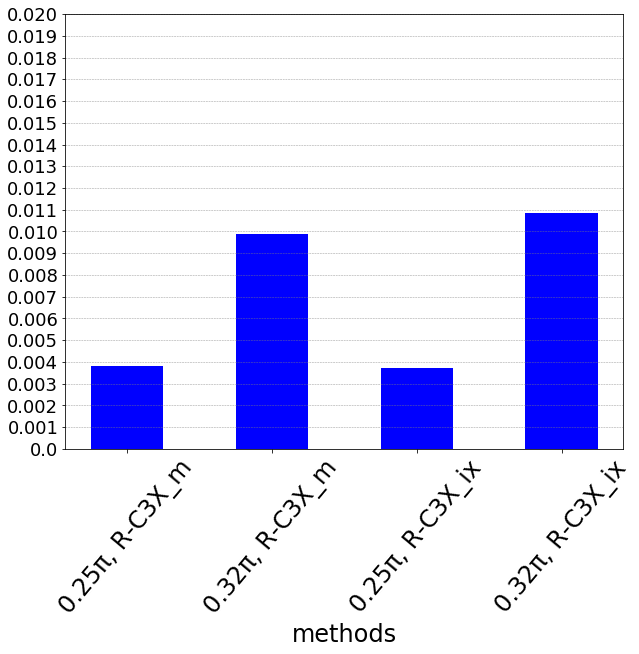

In [66]:
import matplotlib.pyplot as plt
import datetime 

w = 0.5
fig,ax = plt.subplots(figsize=(10, 8))

# plt.title("KL divergence\n"+str(device)+" "+str(datetime.date.today()), fontsize=30)
plt.bar(np.arange(len(kl)), kl, color='b', width=w , align='center')

ax.grid(which = "major", axis = "y", color = "gray", alpha = 0.8,
        linestyle = "--", linewidth = 0.5)
plt.yticks(fontsize=18)
plt.yticks(np.linspace(0, 0.02, 21), ["0.0", "0.001", "0.002", "0.003", "0.004", "0.005", "0.006", "0.007", "0.008", "0.009", "0.010", "0.011", "0.012", "0.013", "0.014", "0.015", "0.016", "0.017", "0.018", "0.019","0.020"])
plt.xlabel("methods", fontsize = 24)
plt.xticks(np.arange(len(methods)), methods, rotation=50,  fontsize=24)

plt.show()